### Установки 

In [90]:
!pip install navec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2023-04-15 17:26:08--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.5MB/s    in 3.1s    

2023-04-15 17:26:12 (16.5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



### Импорты

In [204]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, roc_auc_score, classification_report, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from navec import Navec
import seaborn as sns
import pandas as pd
import numpy as np
import pickle


In [95]:
path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

### Описание задачи

Задачу information extraction можно представить как задачу классификации для фрагментов текста. В нашем случае мы можем выбирать наиболее подходящее предложение из текста. 

Для этого необходимо простроить две модели под каждый label (обеспечение гарантийных обязательств и обеспечение исполнения контракта)


В исходных данных в data preprocessing я увидел очевидный дисбаланс в классификации. Для "обеспечения гарантийных обязательств" доля ответов где мы не могли выбрать подходящее предложение составляла прктически 38%, когда для "обепечения исполнения контракта" таких случаев было всего 4 из 1000.

Поэтому для построения модели "обеспечения гарантийных обязательств" мы введём пороговое значение, выше которого наше предложение будет относиться к выбранному классу, а ниже нет. Такой коэффициент нужно будет подбирать для каждой модели. 

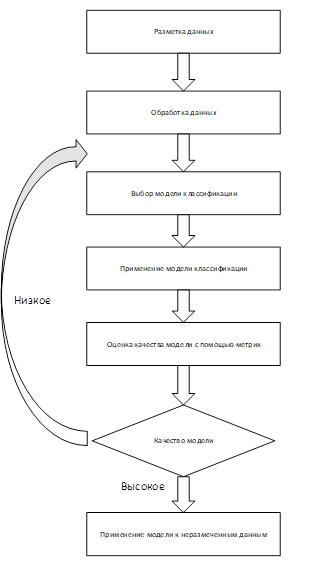

Решение в даном модуле основано на статье: https://telegra.ph/Pajplajn-dlya-sozdaniya-klassifikacii-tekstovoj-informacii-04-13
которая во многом помогла разобраться в задаче классификации текстовой информации. 

### Подготовка датасета

In [146]:
with open('/content/contract_enforcement_lemmatized.pkl', 'rb') as fp:
  contract_enforcement = pickle.load(fp)

In [147]:
with open('/content/garantee_enforcement_lemmatized.pkl', 'rb') as fp:
  garantee_enforcement = pickle.load(fp)

In [148]:
with open('/content/nonetype_lemmatized.pkl', 'rb') as fp:
  nonetype = pickle.load(fp)

In [149]:
def make_dataset(sample_list , target=None):
  dataframe = pd.DataFrame({'text': ['']})
  for i, sentence in enumerate(sample_list):
    dataframe.at[i, 'text'] = sentence
  
  if target is not None:
    dataframe.loc[:, 'target'] = target
  
  return dataframe

In [150]:
contract_enforcement = make_dataset(contract_enforcement, target=1)
len(contract_enforcement)

984

In [151]:
garantee_enforcement = make_dataset(garantee_enforcement, target=1)
len(garantee_enforcement)

508

In [152]:
nonetype_1000 = np.random.choice(nonetype, 1000, replace=False)
nonetype_1000 = make_dataset(nonetype_1000, target=0)
len(nonetype_1000)

<ipython-input-152-5c3a97c41ac2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nonetype_1000 = np.random.choice(nonetype, 1000, replace=False)


1000

In [153]:
contract_enforcement = pd.concat([contract_enforcement, nonetype_1000], axis=0)
contract_enforcement.sample(frac=1)
contract_enforcement.reset_index(drop=True, inplace=True)

In [154]:
garantee_enforcement = pd.concat([garantee_enforcement, nonetype_1000], axis=0)
garantee_enforcement.sample(frac=1)
garantee_enforcement.reset_index(drop=True, inplace=True)


### Построение модели для "обеспечение исполнения контракта"

так как в data preprocessing мы уже разделили тексты в датасете на предложения и из них простроили списки лемм в них, можем использовать готовый датасет train_lemmatized для векторизации. 

In [203]:
def search_best_estimator(model, param_grid, x, y):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_jobs=-1,
        verbose=5
    )
    _ = gs.fit(x, y)
    return gs.best_estimator_

In [184]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(10,8))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

Векторизуем слова с помощью word2vec используя navec_hudlit_v1_12B_500K_300d_100q.tar из https://github.com/natasha/navec?ysclid=lgi8rvqlyo416346758 и в качестве векторов предложений возьмём средние значения word2vec

In [167]:
def get_word_vectors_from_dataframe(dataframe):
  df = []
  for i in range(len(dataframe)):
    sentence = []
    for j in range(len(dataframe.loc[i, 'text'])):
      try:
        word_embending = navec[dataframe.loc[i, 'text'][j]].mean()
        sentence.append(word_embending)
      except:
        sentence.append(0)
    df.append(sentence)
  df = pd.DataFrame(df, dtype='float64')
  df['target'] = dataframe['target']
  df.fillna(0, inplace=True)
  return df
    

In [170]:
contract_enforcement_vectorized = get_word_vectors_from_dataframe(contract_enforcement)
contract_enforcement_vectorized.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,target
1432,0.022990,0.000000,-0.020264,0.016136,0.000000,0.009375,-0.008458,0.028163,0.010537,0.00520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
298,-0.026603,-0.021342,0.010874,-0.006596,-0.028724,0.019443,0.006672,-0.015306,-0.006596,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
74,-0.026603,-0.021342,0.010874,-0.006596,-0.028724,0.019443,0.006672,-0.015306,-0.006596,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1922,0.004908,0.002177,0.002012,0.021475,0.014275,0.000000,0.013794,-0.010312,0.000000,0.01444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1930,0.006776,-0.001345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [189]:
x, y = contract_enforcement_vectorized.drop(columns=['target']), contract_enforcement_vectorized['target'].values

model = RandomForestClassifier()

param_grid = {
"n_estimators": [i for i in range(400, 1000,50)],
"max_depth": [i for i in range(25, 101,25)],
"min_samples_split":[i for i in range(3,10,2)],
"min_samples_leaf": [2 ,3],
}
estimator = search_best_estimator(model, param_grid, x, y)

In [196]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,-0.026603,-0.021342,0.010874,-0.006596,-0.005421,0.004189,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.027181,0.003750,0.000385,-0.021342,0.010874,-0.006596,-0.026603,-0.015306,-0.006596,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.026603,-0.021342,0.010874,-0.006596,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.026603,-0.021342,0.010874,-0.006596,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.026603,-0.021342,0.010874,-0.006596,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
# Делим выборку на тренировочную и валидационную.
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

In [191]:
estimator.fit(x_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=700)

In [192]:
y_pred = estimator.predict(x_test)

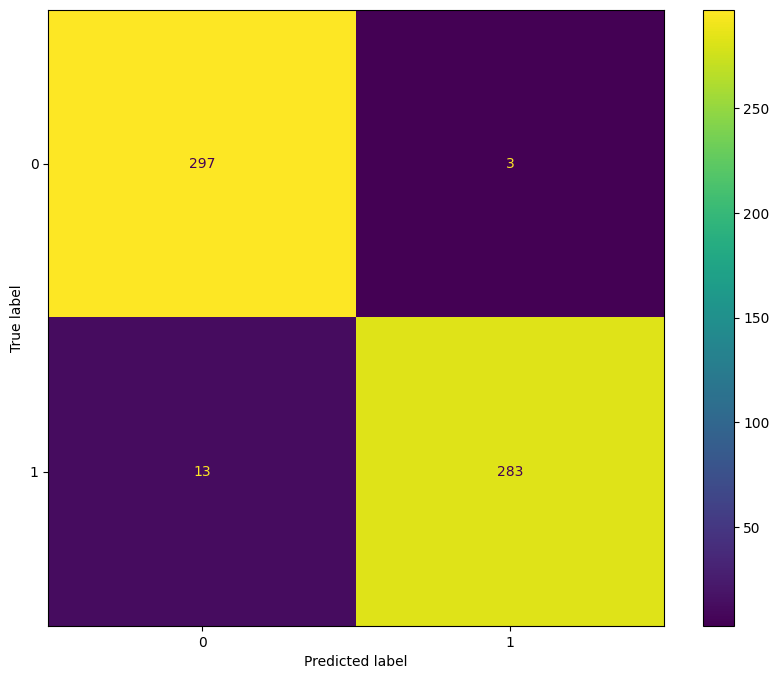

In [193]:
plot_confusion_matrix(y_test, y_pred, estimator)

In [194]:
f1_score(y_test, y_pred)

0.9725085910652921

In [197]:
x, y = contract_enforcement_vectorized.drop(columns=['target']), contract_enforcement_vectorized['target'].values

model = XGBClassifier()

param_grid = {
"n_estimators": [i for i in range(50, 1000,100)],
"max_depth": [i for i in range(25, 101,25)],
"min_samples_split":[i for i in range(3,10,2)],
"min_samples_leaf": [2 ,3],
}
estimator = search_best_estimator(model, param_grid, x, y)

[19:27:50] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



In [198]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

In [199]:
estimator.fit(x_train, y_train)


[19:27:51] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=3,
              missing=nan, monotone_constraints=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

In [200]:
y_pred = estimator.predict(x_test)


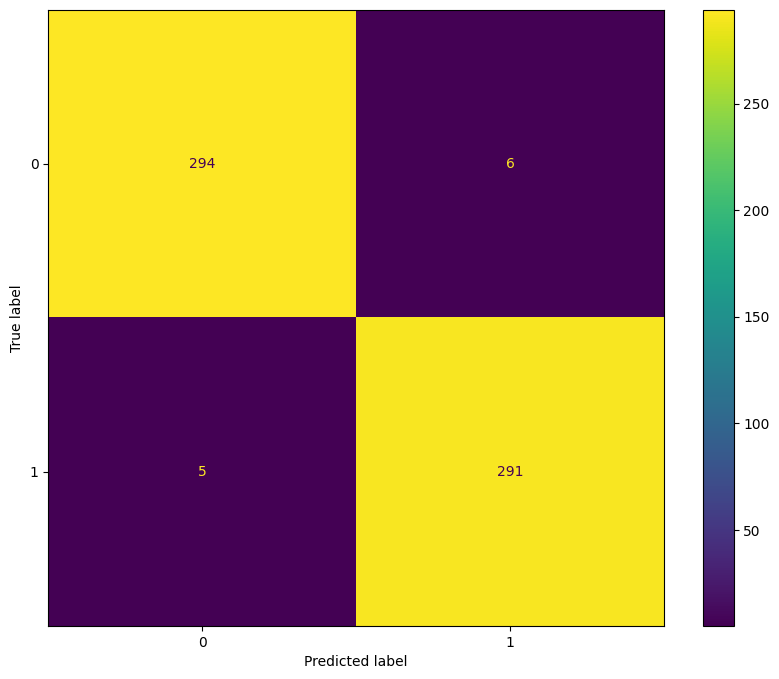

In [201]:
plot_confusion_matrix(y_test, y_pred, estimator)


In [202]:
f1_score(y_test, y_pred)

0.981450252951096

In [206]:
accuracy_score(y_test, y_pred)

0.9815436241610739

0.9815 - хорошая точность 

SetFit на 31 объекте выдаёт 0.9827

на 159 - 0.9986